# ThickBrick tutorial for PyHEP 2020
> Konstantin T. Matchev, Alexander Roman, Prasanth Shyamsundar <img style="float: right;" src="Orange-UF-Monogram.jpg" width=60px><br>
> University of Florida

Package repository: https://gitlab.com/prasanthcakewalk/thickbrick/ <br>
Package website: https://prasanthcakewalk.gitlab.io/thickbrick/

**Based on:** Konstantin K. Matchev, Prasanth Shyamsundar, _"Optimal event selection and categorization in high energy physics, Part 1: Signal discovery"_, [arXiv:1911.12299 [physics.data-an]](https://arxiv.org/abs/1911.12299).

### Requirements to run the tutorial
* Analysis:
    1. thickbrick (==0.1.1)
    2. numpy
* Plotting and visualization:
    1. matplotlib
    2. ipywidgets (can make the notebook work without this)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import IPython.display

plt.rcParams.update({'font.size': 20})

import ipywidgets

orange = '#FA4616' #Gator orange
blue = '#0021A5' #Gator blue

logit = lambda p: np.log(p) - np.log1p(-p)
inv_logit = lambda alpha: np.exp(alpha)/(1+np.exp(alpha))

### What is ThickBrick?
Event selection and categorization
* technique
* python package

Three part series of papers for event selection and categorization in
1. Signal discovery &mdash; _"ThickBrick: Optimal event selection and categorization in high energy physics, Part 1: Signal discovery"_, arXiv:1911.12299 [physics.data-an]
2. Parameter measurement &mdash; future
3. Reducing systematic uncertainties (in signal discovery and param measurement) &mdash; future

### What does part 1 do?
Sets thresholds on ML classifier outputs.
1. Train a BDT or a neural network based classifier.
2. Use ThickBrick to set selection or categorization cuts.<br>
(_"What's the big deal about that?"_)

***
## The physics example
### Background: $pp \rightarrow ZZ \rightarrow \mu^+\mu^-b\bar{b}$
MadGraph process: p p > Z Z, Z > mu+ mu-, Z > b b~
### Signal: $pp \rightarrow ZH \rightarrow (\mu^+\mu^-)(b\bar{b})$
Madgraph process: p p > Z H, Z > mu+ mu-, H > b b~

Let's make it harder!
* $m_\mathrm{Higgs} = 100~\mathrm{GeV}$, to move the Higgs peak closer to the Z peak
* Jet pT resolution = 25%
* Scale down the signal cross-section &mdash; 3 signal events per 100 background events
(used as a familiar proxy)

### 100000 background and 100000 signal events (scaled down by a factor of 0.03)
### $b$ jets manually smeared with $p_T$ resolution = 25%

In [3]:
# Data import
jetres_str = '25'

load_dir = 'data_files/3_thickbrick_input'

tmp = np.loadtxt(f'{load_dir}/background_mjj_p_jetres_{jetres_str}.txt')
bg_mjj, bg_p = tmp[:,0], tmp[:,1]

tmp = np.loadtxt(f'{load_dir}/signal_mjj_p_jetres_{jetres_str}.txt')
sig_mjj, sig_p = tmp[:,0], tmp[:,1]

***
### Analysis goal: Look for the Higgs in the data (can be replaced with a BSM search analysis)
### Discovery variable: Invariant mass of the $b$-jets, $m_{jj}$
#### Signal scaled down by a factor of 0.03 (3 signal events/100 background events)

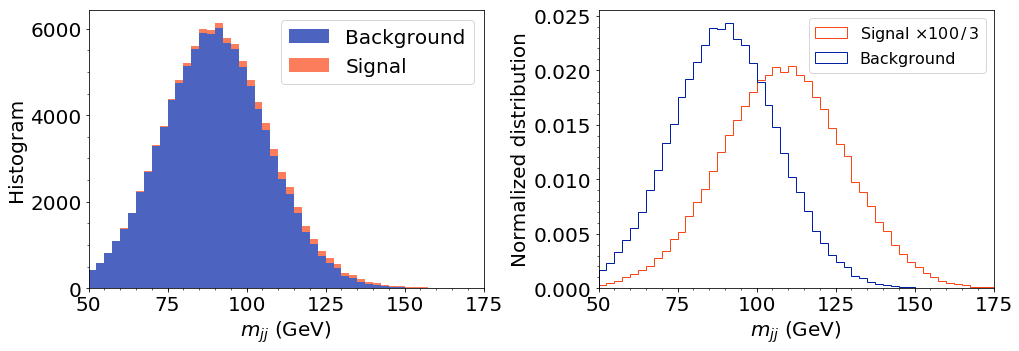

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.tight_layout(pad=3)

signal_scale = 0.03
ax1.hist([bg_mjj, sig_mjj], color=[blue, orange], label=['Background', 'Signal'],
         weights=[np.ones_like(bg_mjj), signal_scale*np.ones_like(sig_mjj)],
         histtype='bar', alpha=.7, stacked=True, bins=50, range=(50, 175))
ax1.set_xlabel(r'$m_{jj}$ (GeV)')
ax1.set_ylabel('Histogram')
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.set_xlim(50, 175)
ax1.legend()

ax2.hist([bg_mjj, sig_mjj], color=[blue, orange], label=['Background', r'Signal $\times 100\,/\,3$'],
         histtype='step', bins=50, density=True, range=(50, 175))
ax2.set_xlabel(r'$m_{jj}$ (GeV)')
ax2.set_ylabel('Normalized distribution')
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.set_xlim(50, 175)
ax2.legend(fontsize=16)

None

## Event selection cuts:

How to make the data signal rich? Placing a cut on $m_{jj}$ will not improve the analysis... Why not?
### Counting experiment $\rightarrow~~\frac{S^2}{B}$ vs $\sum\limits_{i} \frac{s_i^2}{b_i}~~\leftarrow$ Shape analysis
Former can improve with a cut on $m_{jj}$. Latter cannot.

> #### Cuts need to be based on information complementary to $m_{jj}$.

## Machine Learning based classifiers!
We trained a neural network in NN_classifier.ipynb and stored the output. Let's call the output $p$ (for probability of an event being a signal event)

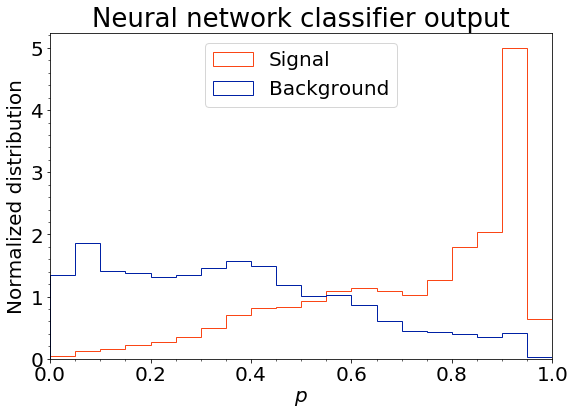

In [5]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.hist([bg_p, sig_p], color=[blue, orange], label=['Background', 'Signal'], histtype='step', bins=20, density=True, range=(0,1))
ax.set_xlabel(r'$p$')
ax.set_ylabel('Normalized distribution')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim(0, 1)
ax.legend(loc=9)
ax.set_title('Neural network classifier output', fontsize=26)
None

### Placing selection cuts on the NN classifier output:

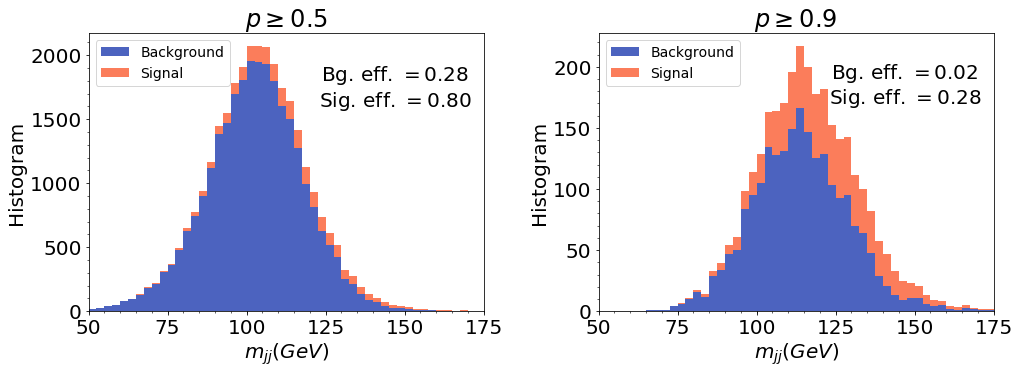

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.tight_layout(pad=3)

for (ax, threshold) in [(axes[0], 0.5), (axes[1], 0.9)]:#, (axes[1][2], .95)]:
    bg_mjj_survive = bg_mjj[np.nonzero(bg_p > threshold)]
    sig_mjj_survive = sig_mjj[np.nonzero(sig_p > threshold)]
    
    ax.hist([bg_mjj_survive, sig_mjj_survive], color=[blue, orange], label=['Background', 'Signal'],
            weights=[np.ones_like(bg_mjj_survive), signal_scale*np.ones_like(sig_mjj_survive)],
            histtype='bar', alpha=.7, stacked=True, bins=50, range=(50, 175))
    ax.set_xlabel(r'$m_{jj} (GeV)$')
    ax.set_ylabel('Histogram')
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlim(50, 175)
    ax.legend(loc=2, fontsize=14)

threshold = 0.5
bg_mjj_survive = bg_mjj[np.nonzero(bg_p > threshold)]
sig_mjj_survive = sig_mjj[np.nonzero(sig_p > threshold)]
axes[0].set_title(f"$p \geq {threshold}$")
axes[0].text(147, 1800, f"Bg. eff. $= {len(bg_mjj_survive)/len(bg_mjj):.2f}$", ha='center')
axes[0].text(147, 1600, f"Sig. eff. $= {len(sig_mjj_survive)/len(sig_mjj):.2f}$", ha='center')

threshold = 0.9
bg_mjj_survive = bg_mjj[np.nonzero(bg_p > threshold)]
sig_mjj_survive = sig_mjj[np.nonzero(sig_p > threshold)]
axes[1].set_title(f"$p \geq {threshold}$")
axes[1].text(147, 190, f"Bg. eff. $= {len(bg_mjj_survive)/len(bg_mjj):.2f}$", ha='center')
axes[1].text(147, 170, f"Sig. eff. $= {len(sig_mjj_survive)/len(sig_mjj):.2f}$", ha='center')

None

### $m_{jj}$ is highly correlated with $p$!

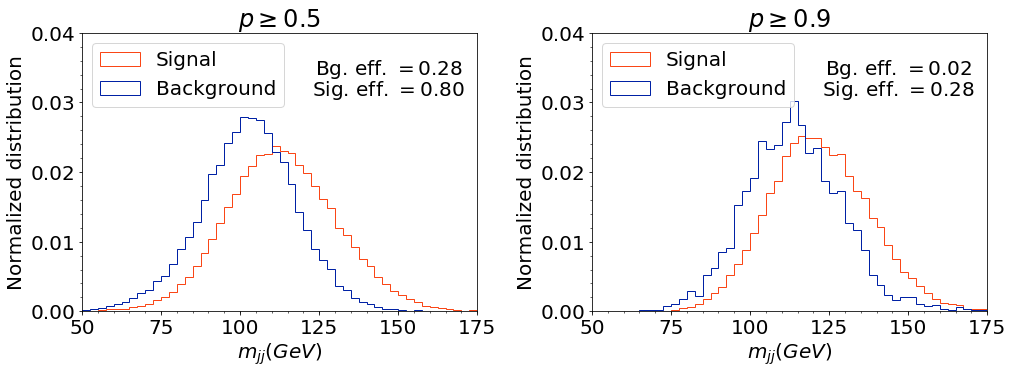

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.tight_layout(pad=3)

for (ax, threshold) in [(axes[0], 0.5), (axes[1], 0.9)]:#, (axes[0][2], .95)]:
    bg_mjj_survive = bg_mjj[np.nonzero(bg_p > threshold)]
    sig_mjj_survive = sig_mjj[np.nonzero(sig_p > threshold)]
    
    ax.hist([bg_mjj_survive, sig_mjj_survive], color=[blue, orange], label=['Background', 'Signal'], histtype='step', bins=50, density=True, range=(50, 175))
    ax.set_xlabel(r'$m_{jj} (GeV)$')
    ax.set_ylabel('Normalized distribution')
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlim(50, 175)
    ax.set_ylim(0, .04)
    ax.legend(loc=2)
    ax.set_title(f"$p \geq {threshold}$")
    ax.text(147, .034, f"Bg. eff. $= {len(bg_mjj_survive)/len(bg_mjj):.2f}$", ha='center')
    ax.text(147, .031, f"Sig. eff. $= {len(sig_mjj_survive)/len(sig_mjj):.2f}$", ha='center')

We said cutting based on $m_{jj}$ is bad. But the NN learns from $m_{jj}$ as well!<br>
**Can we do better?**

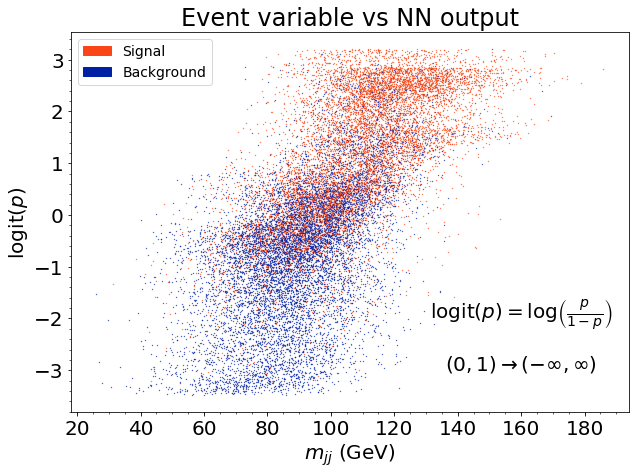

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))

plot_batch_size = 100
plot_batch_count = 100

for i in range(plot_batch_count):
    start, end = i*plot_batch_size, (i+1)*plot_batch_size
    ax.scatter(sig_mjj[start:end], logit(sig_p[start:end]), color=orange, s=.1)
    ax.scatter(bg_mjj[start:end], logit(bg_p[start:end]), color=blue, s=.1)

ax.set_xlabel(r'$m_{jj}$ (GeV)')
ax.set_ylabel(r'$\mathrm{logit}(p)$')

sig_patch = mpatches.Patch(color=orange, label='Signal')
bg_patch = mpatches.Patch(color=blue, label='Background')
ax.legend(handles=[sig_patch, bg_patch], fontsize=14)

ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.text(160, -2, r'$\mathrm{logit}(p) = \log\left(\frac{p}{1-p}\right)$', ha='center')
ax.text(160, -3, r'$(0,1) \rightarrow (-\infty, \infty)$', ha='center')
ax.set_title("Event variable vs NN output")

None

A nominal 'horizontal cut' in $p$ will be too strict for bins on the left and too lenient for bins on the right.

> **Idea:** Make the best out of each bin

Choose a different cut at different values of $m_{jj}$ to maximize $s^2/b$ at each $m_{jj}$ value/bin to maximize $\sum\limits_i \frac{s_i^2}{b_i}$<br>
> **Note:** In the paper we prove that the setting the best bin dependent thresholds $\equiv$ finding the optimal event selector

The task changes from finding one threshold $\longrightarrow$ finding a threshold_func($m_{jj}$)<br>
Great, more work! Enter ThickBrick

In [9]:
import thickbrick as taab
import thickbrick.KernelRegression as kerreg

## Train - test data prep

ThickBrick's inputs are $m_{jj}$-s and the corresponding $p$-s.<br>
$m_{jj}$ is the event variable relevant to the analysis at hand. It can be something else for other analyses.

In [10]:
mjj = np.concatenate([bg_mjj, sig_mjj])
p = np.concatenate([bg_p, sig_p])

np.random.seed(5)
shuffle_index = np.random.permutation(len(mjj))
mjj_train = mjj[shuffle_index]
p_train = p[shuffle_index]

#### Step 0: ThickBrick Choices

In [11]:
style_kwargs = {'style': {'description_width': 'initial'}, 'layout': ipywidgets.Layout(width='50%')}

category_count_widget = ipywidgets.IntText(value=1, 
                                           description='`category_count` (Number of selected categories):', **style_kwargs)
allow_rejection_widget = ipywidgets.Checkbox(value=True,
                                             description='`allow_rejection` (Check to allow event rejection)', indent=False, **style_kwargs)
statistical_distance_widget = ipywidgets.RadioButtons(options=['Neyman_chisq', 'Pearson_chisq','Kullback_Leibler',
                                                               'rev_Kullback_Leibler', 'Jeffreys', 'Bhattacharyya'], value='Pearson_chisq',
                                                      description='`statistical_distance` (to maximize):', **style_kwargs)
initialization_mode_widget = ipywidgets.RadioButtons(description='`initialization_mode`:', options=['all_in_one_category', 'random_assignment'], **style_kwargs)


display(category_count_widget)
display(allow_rejection_widget)
display(initialization_mode_widget)
display(statistical_distance_widget)

IntText(value=1, description='`category_count` (Number of selected categories):', layout=Layout(width='50%'), …

Checkbox(value=True, description='`allow_rejection` (Check to allow event rejection)', indent=False, layout=La…

RadioButtons(description='`initialization_mode`:', layout=Layout(width='50%'), options=('all_in_one_category',…

RadioButtons(description='`statistical_distance` (to maximize):', index=1, layout=Layout(width='50%'), options…

$\texttt{Neyman_chisq} = \displaystyle\sum\limits_c \displaystyle\int dx~\frac{s_c(x)^2}{n_c(x)}$<br>
$\texttt{Pearson_chisq} = \displaystyle\sum\limits_c \displaystyle\int dx~\frac{s_c(x)^2}{b_c(x)}$<br>
$\texttt{Kullback_Leibler} = \displaystyle\sum\limits_c\displaystyle\int dx~\left[-s_c(x) - n_c(x)\ln\left(1 - \frac{s_c(x)}{n_c(x)}\right)\right]$<br>
$\texttt{rev_Kullback_Leibler} = \displaystyle\sum\limits_c\displaystyle\int dx~\left[s_c(x) + b_c(x)\ln\left(1 - \frac{s_c(x)}{n_c(x)}\right)\right]$<br>
$\texttt{Jeffreys} = \displaystyle\sum\limits_c\displaystyle\int dx~\left[-s_c(x)\ln\left(1 - \frac{s_c(x)}{n_c(x)}\right)\right]$<br>
$\texttt{Bhattacharyya} = \displaystyle\sum\limits_c\displaystyle\int dx~\left[n_c(x) - \frac{s_c(x)}{2} - n_c(x)\sqrt{1 - \frac{s_c(x)}{n_c(x)}}\right]$

In [12]:
category_count = category_count_widget.value
allow_rejection = allow_rejection_widget.value
statistical_distance = statistical_distance_widget.value
initialization_mode = initialization_mode_widget.value

print(f'category_count = {repr(category_count)}')
print(f'allow_rejection = {repr(allow_rejection)}')
print(f'statistical_distance = {repr(statistical_distance)}')
print(f'initialization_mode = {repr(initialization_mode)}')

category_count = 1
allow_rejection = True
statistical_distance = 'Pearson_chisq'
initialization_mode = 'all_in_one_category'


#### Step 1: Initialize an Autocategorizer object

In [13]:
autocat = taab.Autocategorizer(category_count=category_count,
                               allow_rejection=allow_rejection,
                               statistical_distance=statistical_distance,
                               regression_method=kerreg.NW_kerreg_1d,
                               default_regression_options={
                                   'kernel':'rectangular', 'bandwidth': 5})

#### Step 2: Set the training data

In [14]:
autocat.set_data(x=mjj_train, p=p_train)

#### Step 3: Initialize the categorizer

In [15]:
np.random.seed(0)
autocat.initialize_categorizer(mode=initialization_mode)

#### Step 4: Train the categorizer iteratively

In [16]:
for i in range(30):
    print(f"Training step {i+1:2}: {autocat.training_step()}")

Training step  1: {'category_reassignment_count': 47188}
Training step  2: {'category_reassignment_count': 24880}
Training step  3: {'category_reassignment_count': 14604}
Training step  4: {'category_reassignment_count': 9286}
Training step  5: {'category_reassignment_count': 6204}
Training step  6: {'category_reassignment_count': 4239}
Training step  7: {'category_reassignment_count': 2891}
Training step  8: {'category_reassignment_count': 1965}
Training step  9: {'category_reassignment_count': 1394}
Training step 10: {'category_reassignment_count': 1006}
Training step 11: {'category_reassignment_count': 731}
Training step 12: {'category_reassignment_count': 530}
Training step 13: {'category_reassignment_count': 373}
Training step 14: {'category_reassignment_count': 247}
Training step 15: {'category_reassignment_count': 182}
Training step 16: {'category_reassignment_count': 144}
Training step 17: {'category_reassignment_count': 120}
Training step 18: {'category_reassignment_count': 76

#### Step 5: Get a snapshot the trained categorizer
Unaffected by future training steps or modifications

In [17]:
cat = autocat.get_current_categorizer()

## Using the trained categorizer

#### 1. Categorizing:
`cat.categorize(event_variable, p)` returns the category to place the event in. `cat(event_variable, p)` also works.
> `-1` is the rejected category<br>
> `0, 1, ..., category_count-1` are the selected categories (increasing order of signal purity).

In [18]:
print(cat.categorize(100, .9))
print(cat.categorize(100, .6))

print(cat.categorize(np.array([80, 90, 100, 110]), np.array([.6, .6, .6, .6])))

0
-1
[ 0  0 -1 -1]


#### 2. Getting the boundaries

In [19]:
print(cat.boundaries(100))

print(cat.boundaries(np.array([80, 90, 100, 110])))

[0.72825948]
[[0.3343835  0.47135451 0.72825948 0.81549588]]


### Let's plot the boundary/boundaries!

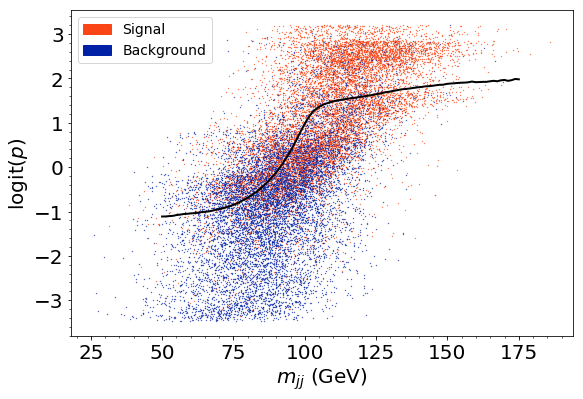

In [20]:
x = np.linspace(50, 175, 100)
p_boundaries = cat.boundaries(x)

fig, ax = plt.subplots(figsize=(9,6))

plot_batch_size = 100
plot_batch_count = 100

for i in range(plot_batch_count):
    start, end = i*plot_batch_size, (i+1)*plot_batch_size
    ax.scatter(sig_mjj[start:end], logit(sig_p[start:end]), color=orange, s=.1)
    ax.scatter(bg_mjj[start:end], logit(bg_p[start:end]), color=blue, s=.1)

ax.set_xlabel(r'$m_{jj}$ (GeV)')
ax.set_ylabel(r'$\mathrm{logit}(p)$')

sig_patch = mpatches.Patch(color=orange, label='Signal')
bg_patch = mpatches.Patch(color=blue, label='Background')
ax.legend(handles=[sig_patch, bg_patch], fontsize=14)

ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator())

x = np.linspace(50, 175, 100)
for i in range(len(p_boundaries)):
    plt.plot(x, logit(p_boundaries[i]), color='black', linewidth=2)

None

In [21]:
category_count = 3
autocat_2 = taab.Autocategorizer(category_count=category_count,
                               allow_rejection=allow_rejection,
                               statistical_distance=statistical_distance,
                               regression_method=kerreg.NW_kerreg_1d,
                               default_regression_options={
                                   'kernel':'rectangular', 'bandwidth': 5})

autocat_2.set_data(x=mjj_train, p=p_train)

autocat_2.initialize_categorizer(mode=initialization_mode)
cat_2_step = [autocat_2.get_current_categorizer()]

for i in range(6):
    print(f"Training step {i+1:2}: {autocat_2.training_step()}")
    cat_2_step.append(autocat_2.get_current_categorizer())

for i in range(6, 50):
    print(f"Training step {i+1:2}: {autocat_2.training_step()}")

cat_2 = autocat_2.get_current_categorizer()

Training step  1: {'category_reassignment_count': 153512}
Training step  2: {'category_reassignment_count': 57119}
Training step  3: {'category_reassignment_count': 24147}
Training step  4: {'category_reassignment_count': 15786}
Training step  5: {'category_reassignment_count': 13079}
Training step  6: {'category_reassignment_count': 12109}
Training step  7: {'category_reassignment_count': 10632}
Training step  8: {'category_reassignment_count': 9327}
Training step  9: {'category_reassignment_count': 7985}
Training step 10: {'category_reassignment_count': 6788}
Training step 11: {'category_reassignment_count': 5625}
Training step 12: {'category_reassignment_count': 4816}
Training step 13: {'category_reassignment_count': 4040}
Training step 14: {'category_reassignment_count': 3422}
Training step 15: {'category_reassignment_count': 2831}
Training step 16: {'category_reassignment_count': 2338}
Training step 17: {'category_reassignment_count': 2033}
Training step 18: {'category_reassignmen

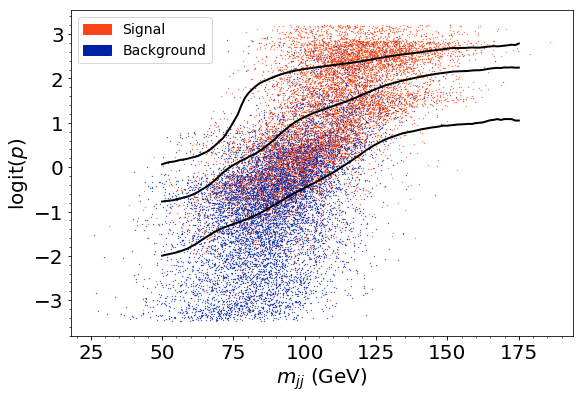

In [22]:
x = np.linspace(50, 175, 100)
p_boundaries = cat_2.boundaries(x)

fig, ax = plt.subplots(figsize=(9,6))

plot_batch_size = 100
plot_batch_count = 100

for i in range(plot_batch_count):
    start, end = i*plot_batch_size, (i+1)*plot_batch_size
    ax.scatter(sig_mjj[start:end], logit(sig_p[start:end]), color=orange, s=.1)
    ax.scatter(bg_mjj[start:end], logit(bg_p[start:end]), color=blue, s=.1)

ax.set_xlabel(r'$m_{jj}$ (GeV)')
ax.set_ylabel(r'$\mathrm{logit}(p)$')

sig_patch = mpatches.Patch(color=orange, label='Signal')
bg_patch = mpatches.Patch(color=blue, label='Background')
ax.legend(handles=[sig_patch, bg_patch], fontsize=14)

x = np.linspace(50, 175, 100)
for i in range(len(p_boundaries)):
    plt.plot(x, logit(p_boundaries[i]), color='black', linewidth=2)

ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator())
None

In [23]:
print(cat_2.categorize(120, inv_logit(-2)))
print(cat_2.categorize(120, inv_logit(1)))
print(cat_2.categorize(120, inv_logit(2)))
print(cat_2.categorize(120, inv_logit(3)))

-1
0
1
2


## Under the hood

### K-means clustering

Inside each "bin", we perform a 1-dimensional K-means clustering based on the $p$-s in that "bin".

Initialize the data points to some categories. In each step,
1. Compute the mean $p$ within each category
2. Calculate new boundaries, based on these means.<br>
   The boundaries depend on the chosen distance measure.
3. Re-categorize

Except, we do this without binning &mdash; hence the kernelregression (revisit that part of the notebook)

Proof of correctness of this procedure is in the paper.

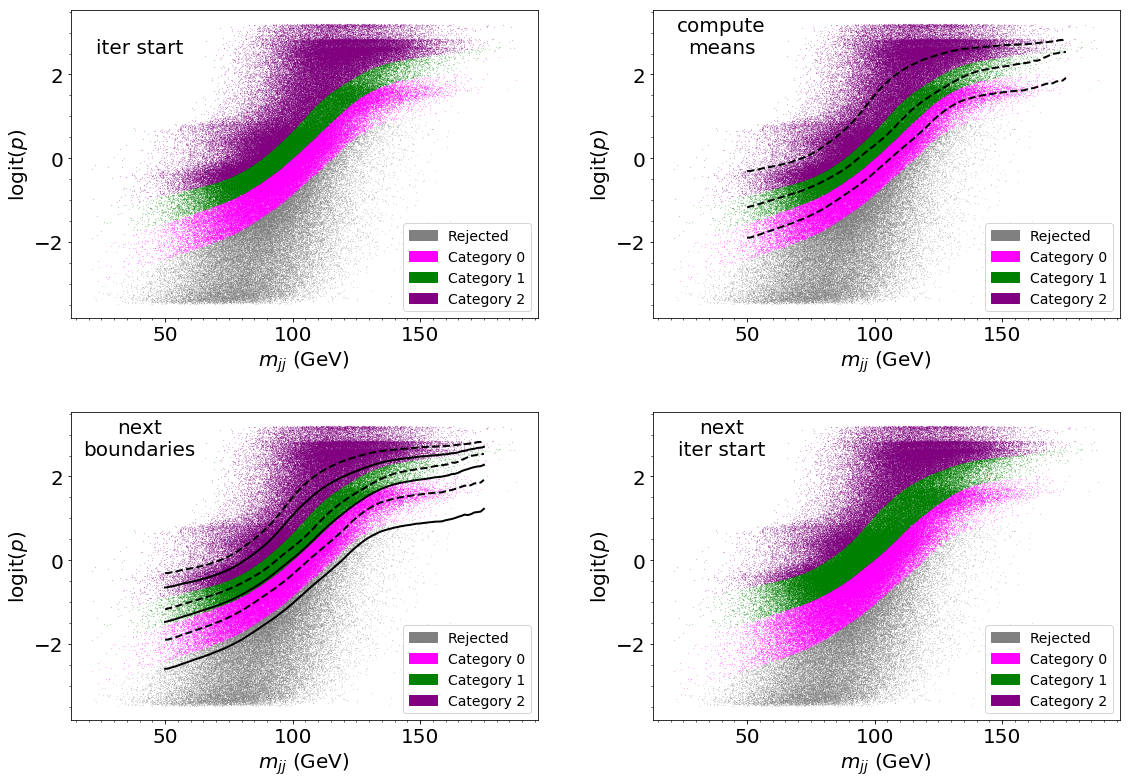

In [24]:
x = np.linspace(50, 175, 100)

fig, axes = plt.subplots(2, 2, figsize=(17,12))
fig.tight_layout(pad=3)

ax.set_xlabel(r'$m_{jj}$')
ax.set_ylabel(r'$p$')

rej_patch = mpatches.Patch(color='gray', label='Rejected')
cat_0_patch = mpatches.Patch(color='magenta', label='Category 0')
cat_1_patch = mpatches.Patch(color='green', label='Category 1')
cat_2_patch = mpatches.Patch(color='purple', label='Category 2')

rej_index = np.nonzero(cat_2_step[2].categorize(mjj_train, p_train) == -1)
cat_0_index = np.nonzero(cat_2_step[2].categorize(mjj_train, p_train) == 0)
cat_1_index = np.nonzero(cat_2_step[2].categorize(mjj_train, p_train) == 1)
cat_2_index = np.nonzero(cat_2_step[2].categorize(mjj_train, p_train) == 2)

ax = axes[0][0]
ax.scatter(mjj_train[rej_index], logit(p_train[rej_index]), color='gray', s=.01)
ax.scatter(mjj_train[cat_0_index], logit(p_train[cat_0_index]), color='magenta', s=.01)
ax.scatter(mjj_train[cat_1_index], logit(p_train[cat_1_index]), color='green', s=.01)
ax.scatter(mjj_train[cat_2_index], logit(p_train[cat_2_index]), color='purple', s=.01)

ax = axes[0][1]
ax.scatter(mjj_train[rej_index], logit(p_train[rej_index]), color='gray', s=.01)
ax.scatter(mjj_train[cat_0_index], logit(p_train[cat_0_index]), color='magenta', s=.01)
ax.scatter(mjj_train[cat_1_index], logit(p_train[cat_1_index]), color='green', s=.01)
ax.scatter(mjj_train[cat_2_index], logit(p_train[cat_2_index]), color='purple', s=.01)

for func in cat_2_step[3].prev_category_means_oracle:
    ax.plot(x, logit(func(x)), color='black', linewidth=2, linestyle = 'dashed')

ax = axes[1][0]
ax.scatter(mjj_train[rej_index], logit(p_train[rej_index]), color='gray', s=.01)
ax.scatter(mjj_train[cat_0_index], logit(p_train[cat_0_index]), color='magenta', s=.01)
ax.scatter(mjj_train[cat_1_index], logit(p_train[cat_1_index]), color='green', s=.01)
ax.scatter(mjj_train[cat_2_index], logit(p_train[cat_2_index]), color='purple', s=.01)

for func in cat_2_step[3].prev_category_means_oracle:
    ax.plot(x, logit(func(x)), color='black', linewidth=2, linestyle = 'dashed')

for boundary in cat_2_step[3].boundaries(x):
    ax.plot(x, logit(boundary), color='black', linewidth=2)

rej_index = np.nonzero(cat_2_step[3].categorize(mjj_train, p_train) == -1)
cat_0_index = np.nonzero(cat_2_step[3].categorize(mjj_train, p_train) == 0)
cat_1_index = np.nonzero(cat_2_step[3].categorize(mjj_train, p_train) == 1)
cat_2_index = np.nonzero(cat_2_step[3].categorize(mjj_train, p_train) == 2)

ax = axes[1][1]
ax.scatter(mjj_train[rej_index], logit(p_train[rej_index]), color='gray', s=.01)
ax.scatter(mjj_train[cat_0_index], logit(p_train[cat_0_index]), color='magenta', s=.01)
ax.scatter(mjj_train[cat_1_index], logit(p_train[cat_1_index]), color='green', s=.01)
ax.scatter(mjj_train[cat_2_index], logit(p_train[cat_2_index]), color='purple', s=.01)

for i in range(2):
    for j in range(2):
        ax = axes[i][j]
        ax.xaxis.set_minor_locator(MultipleLocator(5))
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.legend(handles=[rej_patch, cat_0_patch, cat_1_patch, cat_2_patch], fontsize=14, loc=4)
        ax.set_xlabel(r'$m_{jj}$ (GeV)')
        ax.set_ylabel(r'$\mathrm{logit}(p)$')

axes[0][0].text(40, 2.5, 'iter start', ha='center')
axes[0][1].text(40, 2.5, 'compute\nmeans', ha='center')
axes[1][0].text(40, 2.5, 'next\nboundaries', ha='center')
axes[1][1].text(40, 2.5, 'next\niter start', ha='center')

None

### The converged categorizer

Like with any ML technique, the practitioner's role is important (to avoid overfitting and such)

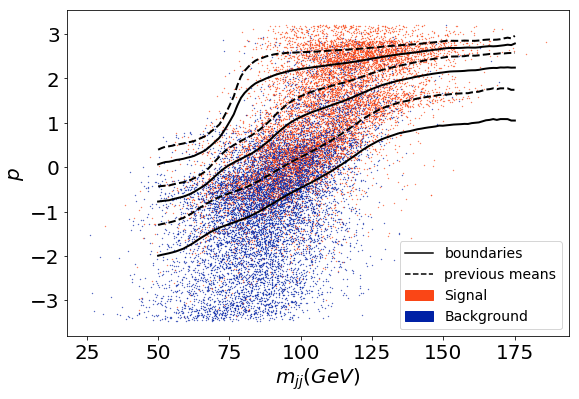

In [25]:
x = np.linspace(50, 175, 100)

fig, ax = plt.subplots(figsize=(9,6))

plot_batch_size = 100
plot_batch_count = 100

for i in range(plot_batch_count):
    start, end = i*plot_batch_size, (i+1)*plot_batch_size
    ax.scatter(sig_mjj[start:end], logit(sig_p[start:end]), color=orange, s=.1)
    ax.scatter(bg_mjj[start:end], logit(bg_p[start:end]), color=blue, s=.1)

ax.set_xlabel(r'$m_{jj} (GeV)$')
ax.set_ylabel(r'$p$')

sig_patch = mpatches.Patch(color=orange, label='Signal')
bg_patch = mpatches.Patch(color=blue, label='Background')
None


for boundary in cat_2.boundaries(x):
    plt.plot(x, logit(boundary), color='black', linewidth=2)

for func in cat_2.prev_category_means_oracle:
    plt.plot(x, logit(func(x)), color='black', linewidth=2, linestyle='dashed')

boundary_label = mlines.Line2D([], [], color='black', label='boundaries')
mean_label = mlines.Line2D([], [], color='black', linestyle='dashed', label='previous means')

ax.legend(handles=[boundary_label, mean_label, sig_patch, bg_patch], fontsize=14)
None

## Back to the event selector we trained earlier

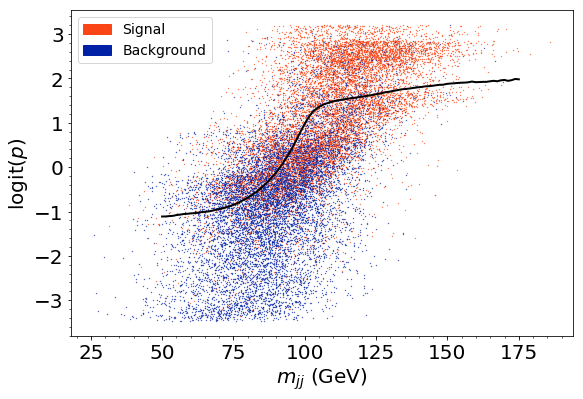

In [26]:
x = np.linspace(50, 175, 100)
p_boundaries = cat.boundaries(x)

fig, ax = plt.subplots(figsize=(9,6))

plot_batch_size = 100
plot_batch_count = 100

for i in range(plot_batch_count):
    start, end = i*plot_batch_size, (i+1)*plot_batch_size
    ax.scatter(sig_mjj[start:end], logit(sig_p[start:end]), color=orange, s=.1)
    ax.scatter(bg_mjj[start:end], logit(bg_p[start:end]), color=blue, s=.1)

ax.set_xlabel(r'$m_{jj}$ (GeV)')
ax.set_ylabel(r'$\mathrm{logit}(p)$')

sig_patch = mpatches.Patch(color=orange, label='Signal')
bg_patch = mpatches.Patch(color=blue, label='Background')
ax.legend(handles=[sig_patch, bg_patch], fontsize=14)

ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator())

x = np.linspace(50, 175, 100)
for i in range(len(p_boundaries)):
    plt.plot(x, logit(p_boundaries[i]), color='black', linewidth=2)

None

In [27]:
# Best flat cut

evaluator = taab.Evaluator(statistical_distance='Pearson_chisq',
                           regression_method=kerreg.NW_kerreg_1d,
                           default_regression_options={
                               'kernel':'rectangular', 'bandwidth': 5})
scores = []

evaluator.set_data(mjj_train, p_train)
for cut in np.linspace(.8, .99, 500):
    flat_cut_categorizer = taab.FunctionalCategorizer(lambda x, p: np.where(p > cut, 0, -1))
    score = evaluator.evaluate(flat_cut_categorizer, category_count=1)
    scores.append((score, cut))

print(max(scores))

print(f"Best flat cut is p >= {max(scores)[1]}")

(2.1048250641402135, 0.8327454909819639)
Best flat cut is p >= 0.8327454909819639


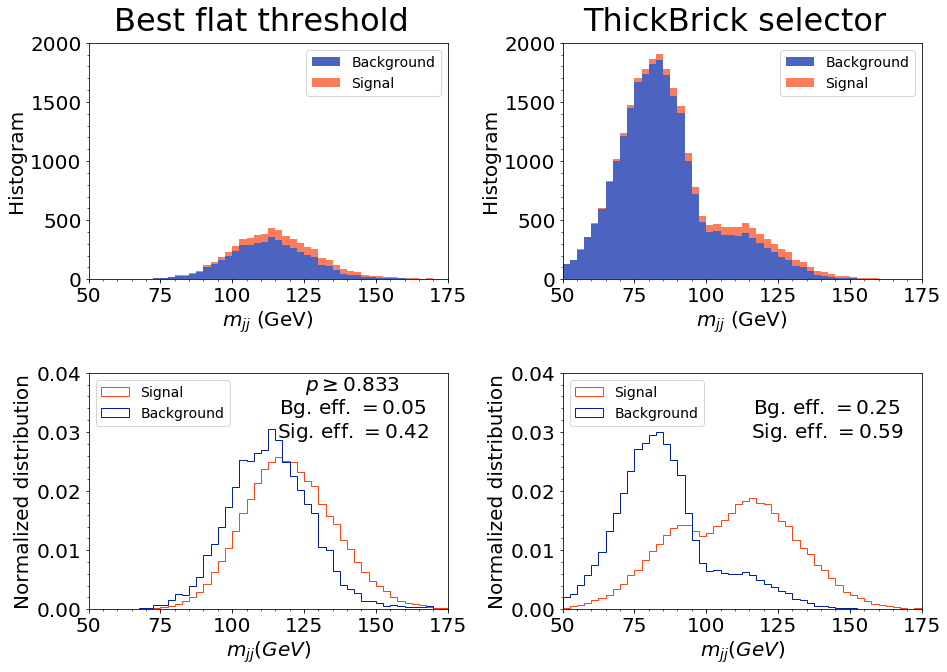

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.tight_layout(pad=3)

threshold=.833
bg_mjj_survive = bg_mjj[np.nonzero(bg_p > threshold)]
sig_mjj_survive = sig_mjj[np.nonzero(sig_p > threshold)]

ax = axes[1][0]
ax.hist([bg_mjj_survive, sig_mjj_survive], color=[blue, orange], label=['Background', 'Signal'], histtype='step', bins=50, density=True, range=(50, 175))
ax.text(142, .037, f"$p \geq {threshold}$", ha='center')
ax.text(142, .033, f"Bg. eff. $= {len(bg_mjj_survive)/len(bg_mjj):.2f}$", ha='center')
ax.text(142, .029, f"Sig. eff. $= {len(sig_mjj_survive)/len(sig_mjj):.2f}$", ha='center')

ax = axes[0][0]
ax.hist([bg_mjj_survive, sig_mjj_survive], color=[blue, orange], label=['Background', 'Signal'],
                weights=[np.ones_like(bg_mjj_survive), signal_scale*np.ones_like(sig_mjj_survive)],
                histtype='bar', alpha=.7, stacked=True, bins=50, range=(50, 175))
ax.text(110, 2100, f"Best flat threshold", ha='center', fontsize=32)


bg_mjj_survive = bg_mjj[np.nonzero(cat(bg_mjj, bg_p)==0)[0]]
sig_mjj_survive = sig_mjj[np.nonzero(cat(sig_mjj, sig_p)==0)[0]]
ax = axes[1][1]
ax.hist([bg_mjj_survive, sig_mjj_survive], color=[blue, orange], label=['Background', 'Signal'],
        histtype='step', bins=50, density=True, range=(50, 175))

ax.text(142, .033, f"Bg. eff. $= {len(bg_mjj_survive)/len(bg_mjj):.2f}$", ha='center')
ax.text(142, .029, f"Sig. eff. $= {len(sig_mjj_survive)/len(sig_mjj):.2f}$", ha='center')

ax = axes[0][1]
ax.hist([bg_mjj_survive, sig_mjj_survive], color=[blue, orange], label=['Background', 'Signal'],
                weights=[np.ones_like(bg_mjj_survive), signal_scale*np.ones_like(sig_mjj_survive)],
                histtype='bar', alpha=.7, stacked=True, bins=50, range=(50, 175))
ax.text(110, 2100, f"ThickBrick selector", ha='center', fontsize=32)

for ax in axes[1]:
    ax.set_xlabel(r'$m_{jj} (GeV)$')
    ax.set_ylabel('Normalized distribution')
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlim(50, 175)
    ax.set_ylim(0, .04)
    ax.legend(loc=2, fontsize=14)

for ax in axes[0]:
    ax.set_xlabel(r'$m_{jj}$ (GeV)')
    ax.set_ylabel('Histogram')
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlim(50, 175)
    ax.set_ylim(0, 2000)
    ax.legend(loc=1, fontsize=14)
    
None

/usr/lib/python3/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


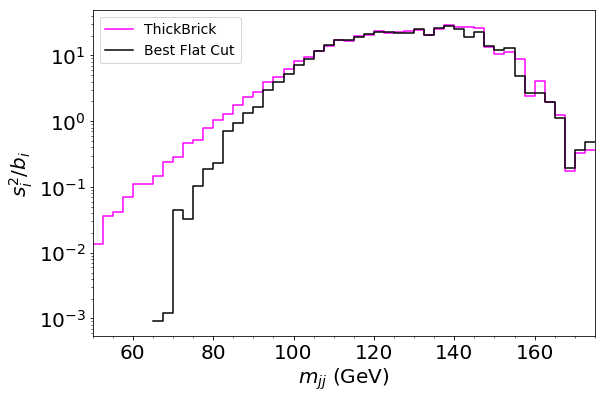

In [29]:
fig, ax = plt.subplots(figsize=(9, 6))

bg_mjj_survive = bg_mjj[np.nonzero(cat(bg_mjj, bg_p)==0)[0]]
sig_mjj_survive = sig_mjj[np.nonzero(cat(sig_mjj, sig_p)==0)[0]]

bg_hist_thickbrick = np.histogram(bg_mjj_survive, bins=50, range=(50, 175))
sig_hist_thickbrick = np.histogram(sig_mjj_survive, bins=50, range=(50, 175))
sigsqoverb_thickbrick = (0.03*sig_hist_thickbrick[0])**2/bg_hist_thickbrick[0]
sigsqoverb_thickbrick = np.append(sigsqoverb_thickbrick, sigsqoverb_thickbrick[-1])
ax.plot(np.linspace(50, 175, 51), sigsqoverb_thickbrick, drawstyle='steps-post',
         color='magenta', label='ThickBrick')

threshold = .833
bg_mjj_survive = bg_mjj[np.nonzero(bg_p > threshold)]
sig_mjj_survive = sig_mjj[np.nonzero(sig_p > threshold)]

bg_hist_flatcut = np.histogram(bg_mjj_survive, bins=50, range=(50, 175))
sig_hist_flatcut = np.histogram(sig_mjj_survive, bins=50, range=(50, 175))
sigsqoverb_flatcut = ((0.03*sig_hist_flatcut[0])**2/bg_hist_flatcut[0])
sigsqoverb_flatcut = np.append(sigsqoverb_flatcut, sigsqoverb_flatcut[-1])
ax.plot(np.linspace(50, 175, 51), sigsqoverb_flatcut, drawstyle='steps-post',
         color='black', label='Best Flat Cut')

ax.set_xlabel(r'$m_{jj}$ (GeV)')
ax.set_ylabel(r'$s_i^2 / b_i$')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.set_xlim(50, 175)
ax.set_yscale('log')

ax.legend(fontsize=14)
None

## Other features...
1. There is an evaluator class `taab.Evaluator`.<br>
Similar to `taab.AutoCategorizer`. One is for training, the other is for testing/validating.
2. Adjusting signal scale...<br>
The selector that maximizes $\sum s^2/b$ doesn't change by the transformatiuon $s \rightarrow \lambda s$.<br>
But other distances don't share this property...<br>
`autocat.training_step(signal_scale=0.03)` let's use set the signal scale.

## Moving forward
* Write part 2 (optimal selection for parameter measurement)<br>
and part 3 (reducing systematics using event selection).
* Incorporate the functionality from parts 2 and 3 into the ThickBrick package.
* We would be happy to help out with
     - Adoption of the technique in a real analysis or test study
     - Incorporating the ThickBrick implementation in a larger package

## Questions?

### <div style="text-align: right"> Other remarks... </div>